In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(conn, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(conn)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

t_min, t_avg, t_max = calc_temps('2012-01-01', '2013-01-01')[0]
print(t_min, t_avg, t_max)

56.0 72.26001511715798 86.0


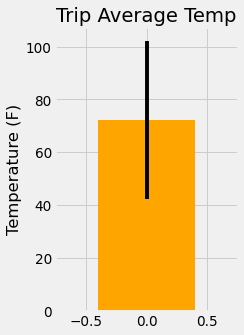

In [18]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ptp_error = t_max - t_min
plt.figure(figsize=(3, 5), dpi=70)
plt.bar(0,t_avg, yerr = ptp_error, color = 'orange')
plt.xlim(-.75, .75)
plt.ylabel('Temperature (F)')
plt.title("Trip Average Temp")
plt.savefig("Images/trip_avg_temp.png")

plt.show()


### Daily Rainfall Average

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = "2012-01-01"
end_date = "2012-02-01"

def precipation_sum(start_date, end_date):
    sel = [Station.station,Station.latitude, Station.latitude, Station.elevation, func.sum(Measurement.prcp)]
    results = session.query(*sel)\
        .filter(Station.station == Measurement.station)\
        .group_by(Measurement.station).\
            filter(Measurement.date >= start_date).\
                filter(Measurement.date <= end_date)\
                    .order_by(func.sum(Measurement.prcp).desc()).all()
    results_df = pd.DataFrame(results, columns = ['station_name','station_latitude','station_longitude','station_elevation','total_rain'])
    return results_df

df = precipation_sum(start_date, end_date)
df

,station_name,station_latitude,station_longitude,station_elevation,total_rain
0,USC00519281,21.45167,21.45167,32.9,3.19
1,USC00518838,21.49920,21.49920,306.6,2.92
2,USC00516128,21.33310,21.33310,152.4,1.99
3,USC00519397,21.27160,21.27160,3.0,1.17
4,USC00514830,21.52130,21.52130,7.0,1.16
5,USC00513117,21.42340,21.42340,14.6,0.67
6,USC00519523,21.33556,21.33556,19.5,0.56
7,USC00511918,21.31520,21.31520,0.9,0.38
8,USC00517948,21.39340,21.39340,11.9,0.33


In [20]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime.strptime('2017-08-01', "%Y-%m-%d")
end_date = dt.datetime.strptime('2017-08-08',"%Y-%m-%d")

normal = []
delta_date = start_date


# Use the start and end date to create a range of dates
delta_time = end_date - start_date

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
if start_date <= end_date:
    for day in range(delta_time.days):
        delta_date += dt.timedelta(days = 1)
        # Strip off the year and save a list of strings in the format %m-%d
        tmin, tavg, tmax = daily_normals(delta_date.strftime('%m-%d'))[0]
        normal.append([delta_date.strftime("%Y-%m-%d"),tmin, round(tavg,3), tmax])
        print(normal)


[['2017-08-02', 68.0, 75.604, 84.0]]
[['2017-08-02', 68.0, 75.604, 84.0], ['2017-08-03', 70.0, 76.611, 85.0]]
[['2017-08-02', 68.0, 75.604, 84.0], ['2017-08-03', 70.0, 76.611, 85.0], ['2017-08-04', 69.0, 76.712, 84.0]]
[['2017-08-02', 68.0, 75.604, 84.0], ['2017-08-03', 70.0, 76.611, 85.0], ['2017-08-04', 69.0, 76.712, 84.0], ['2017-08-05', 69.0, 76.148, 82.0]]
[['2017-08-02', 68.0, 75.604, 84.0], ['2017-08-03', 70.0, 76.611, 85.0], ['2017-08-04', 69.0, 76.712, 84.0], ['2017-08-05', 69.0, 76.148, 82.0], ['2017-08-06', 67.0, 76.25, 83.0]]
[['2017-08-02', 68.0, 75.604, 84.0], ['2017-08-03', 70.0, 76.611, 85.0], ['2017-08-04', 69.0, 76.712, 84.0], ['2017-08-05', 69.0, 76.148, 82.0], ['2017-08-06', 67.0, 76.25, 83.0], ['2017-08-07', 71.0, 77.157, 83.0]]
[['2017-08-02', 68.0, 75.604, 84.0], ['2017-08-03', 70.0, 76.611, 85.0], ['2017-08-04', 69.0, 76.712, 84.0], ['2017-08-05', 69.0, 76.148, 82.0], ['2017-08-06', 67.0, 76.25, 83.0], ['2017-08-07', 71.0, 77.157, 83.0], ['2017-08-08', 68.0, 76.

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normal, columns = ['date','tmin', 'tavg', 'tmax'])
normal_df_index = normal_df.set_index('date')

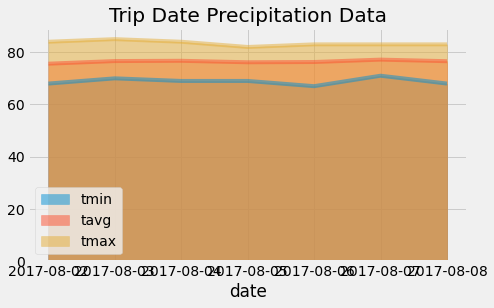

In [25]:


# Plot the daily normals as an area plot with `stacked=False`
normal_df_index.plot.area(stacked = False, figsize = (7,4))
plt.title("Trip Date Precipitation Data")
plt.savefig("Images/trip_precipitation_data.png")

plt.show()
# plt.xticks(rotation = 90)

## Close Session

In [26]:
session.close()